# Análisis de Ventas con PySpark
Este notebook realiza análisis de datos de ventas usando Spark

In [1]:
# Importar configuraciones
import sys
import os
sys.path.append(os.path.abspath('./src'))
os.makedirs("resultados", exist_ok=True)

from config.spark_config import SparkSession
from etl.transformaciones import TransformacionesVentas
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.getActiveSession()
if spark:
    spark.stop()
    
# Inicializar Spark
spark = SparkSession.builder \
    .appName("AnalisisVentas-Notebook") \
    .enableHiveSupport() \
    .getOrCreate()

26/02/12 22:59:04 WARN Utils: Your hostname, LenovoLOQ resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/02/12 22:59:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/12 22:59:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/12 22:59:06 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
transformaciones = TransformacionesVentas(spark)

In [4]:
spark.conf.get("spark.sql.catalogImplementation")

'hive'

In [5]:
# %%
# Cargar datos
ventas_df, productos_df = transformaciones.cargar_datos()

print("📊 Vista previa de ventas:")
ventas_df.show(5)

print("\n📦 Vista previa de productos:")
productos_df.show(5)

print(f"\nTotal ventas: {ventas_df.count()}")
print(f"Total productos: {productos_df.count()}")

📂 Cargando datos...


📊 Vista previa de ventas:


+--------+-----------+--------+---------------+----------+----------+
|venta_id|producto_id|cantidad|precio_unitario|     fecha|cliente_id|
+--------+-----------+--------+---------------+----------+----------+
|       1|        101|       2|           10.5|2024-01-15|      1001|
|       2|        102|       1|           25.0|2024-01-15|      1002|
|       3|        101|       3|           10.5|2024-01-16|      1001|
|       4|        103|       2|          15.75|2024-01-16|      1003|
|       5|        104|       1|           30.0|2024-01-17|      1004|
+--------+-----------+--------+---------------+----------+----------+
only showing top 5 rows


📦 Vista previa de productos:
+-----------+-------+-----------+-----+
|producto_id| nombre|  categoria|stock|
+-----------+-------+-----------+-----+
|        101| Laptop|Electrónica|   50|
|        102|  Mouse|  Accesorio|  200|
|        103|Teclado|  Accesorio|  150|
|        104|Monitor|Electrónica|   75|
|        105|    USB|  Accesorio|  

In [6]:
# %%
# Esquema de datos
print("Esquema ventas:")
ventas_df.printSchema()

print("\nEsquema productos:")
productos_df.printSchema()

Esquema ventas:
root
 |-- venta_id: integer (nullable = true)
 |-- producto_id: integer (nullable = true)
 |-- cantidad: integer (nullable = true)
 |-- precio_unitario: double (nullable = true)
 |-- fecha: date (nullable = true)
 |-- cliente_id: integer (nullable = true)


Esquema productos:
root
 |-- producto_id: integer (nullable = true)
 |-- nombre: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- stock: integer (nullable = true)



In [7]:
# %%
# Calcular métricas
ventas_completas_df, metricas_df = transformaciones.calcular_metricas(ventas_df, productos_df)

print("📈 Métricas por categoría:")
metricas_df.show()

📈 Métricas por categoría:
+-----------+-------+-------------+----------------+---------------+-------------+
|  categoria| nombre|total_vendido|ingresos_totales|precio_promedio|transacciones|
+-----------+-------+-------------+----------------+---------------+-------------+
|  Accesorio|  Mouse|            5|           125.0|           25.0|            2|
|Electrónica|Monitor|            4|           120.0|           30.0|            2|
|Electrónica| Laptop|            7|            73.5|           10.5|            3|
|  Accesorio|Teclado|            3|           47.25|          15.75|            2|
|  Accesorio|    USB|            2|           17.98|           8.99|            1|
+-----------+-------+-------------+----------------+---------------+-------------+



In [8]:
# %%
# Análisis temporal
analisis_temporal_df = transformaciones.analisis_temporal(ventas_df)

print("📅 Análisis por fecha:")
analisis_temporal_df.show()

📅 Análisis por fecha:
+----------+--------------+------------+---------------+----------------------+
|     fecha|total_unidades|venta_diaria|clientes_unicos|precio_promedio_diario|
+----------+--------------+------------+---------------+----------------------+
|2024-01-15|             3|        46.0|              2|                 17.75|
|2024-01-16|             5|        63.0|              2|                13.125|
|2024-01-17|             5|       130.0|              2|                  27.5|
|2024-01-18|             3|       36.75|              2|                13.125|
|2024-01-19|             5|      107.98|              2|                19.495|
+----------+--------------+------------+---------------+----------------------+



In [9]:
# %%
# Top clientes
top_clientes_df = transformaciones.top_clientes(ventas_df, top_n=5)

print("👑 Top 5 clientes:")
top_clientes_df.show()

👑 Top 5 clientes:
+----------+-------------+-----------+
|cliente_id|total_compras|gasto_total|
+----------+-------------+-----------+
|      1002|            5|      125.0|
|      1004|            4|      120.0|
|      1001|            5|       52.5|
|      1003|            3|      47.25|
|      1005|            2|       21.0|
+----------+-------------+-----------+



In [10]:
# %%
# Análisis adicional: Ventas por producto
ventas_por_producto = ventas_completas_df.groupBy("nombre", "categoria") \
    .agg(
        F.sum("cantidad").alias("unidades_vendidas"),
        F.sum("venta_total").alias("ingresos"),
        F.round(F.avg("precio_unitario"), 2).alias("precio_promedio")
    ) \
    .orderBy(F.desc("ingresos"))

print("🏆 Productos más vendidos:")
ventas_por_producto.show()

🏆 Productos más vendidos:
+-------+-----------+-----------------+--------+---------------+
| nombre|  categoria|unidades_vendidas|ingresos|precio_promedio|
+-------+-----------+-----------------+--------+---------------+
|  Mouse|  Accesorio|                5|   125.0|           25.0|
|Monitor|Electrónica|                4|   120.0|           30.0|
| Laptop|Electrónica|                7|    73.5|           10.5|
|Teclado|  Accesorio|                3|   47.25|          15.75|
|    USB|  Accesorio|                2|   17.98|           8.99|
+-------+-----------+-----------------+--------+---------------+



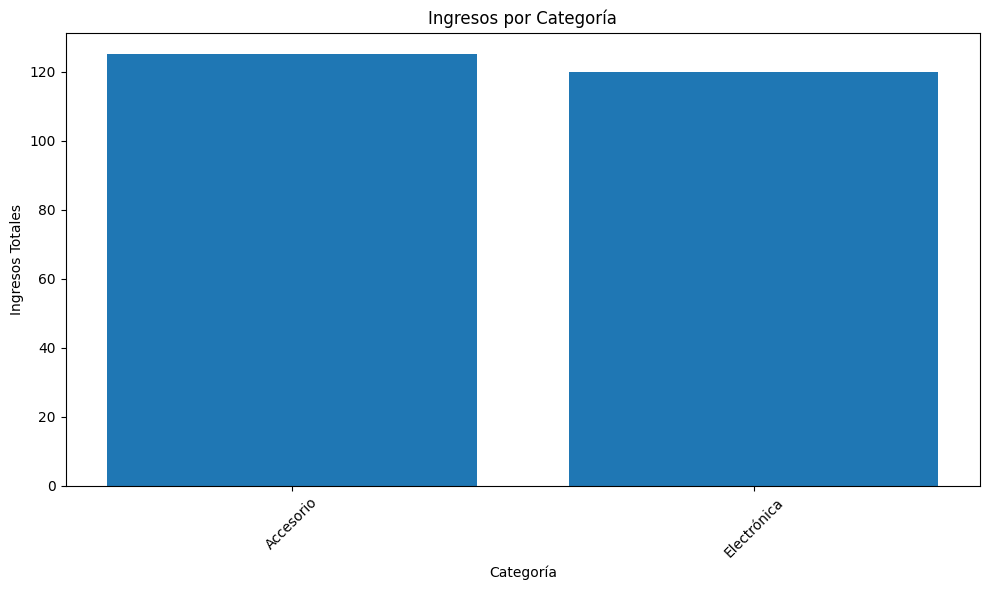

In [11]:
# %%
# Visualización (si matplotlib está disponible)
try:
    import matplotlib.pyplot as plt
    
    # Convertir a pandas para visualización
    metricas_pandas = metricas_df.toPandas()
    
    plt.figure(figsize=(10, 6))
    plt.bar(metricas_pandas['categoria'], metricas_pandas['ingresos_totales'])
    plt.title('Ingresos por Categoría')
    plt.xlabel('Categoría')
    plt.ylabel('Ingresos Totales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("Matplotlib no disponible para visualización")

In [12]:
metricas_df.printSchema()
metricas_df.show()

root
 |-- categoria: string (nullable = true)
 |-- nombre: string (nullable = true)
 |-- total_vendido: long (nullable = true)
 |-- ingresos_totales: double (nullable = true)
 |-- precio_promedio: double (nullable = true)
 |-- transacciones: long (nullable = false)

+-----------+-------+-------------+----------------+---------------+-------------+
|  categoria| nombre|total_vendido|ingresos_totales|precio_promedio|transacciones|
+-----------+-------+-------------+----------------+---------------+-------------+
|  Accesorio|  Mouse|            5|           125.0|           25.0|            2|
|Electrónica|Monitor|            4|           120.0|           30.0|            2|
|Electrónica| Laptop|            7|            73.5|           10.5|            3|
|  Accesorio|Teclado|            3|           47.25|          15.75|            2|
|  Accesorio|    USB|            2|           17.98|           8.99|            1|
+-----------+-------+-------------+----------------+---------------+-

In [13]:
# Modo no profesional
# Guardar resultados
print("💾 Guardando resultados...")

# Guardar como Parquet (formato optimizado para Spark)
metricas_df.write.mode("overwrite").parquet("file:///home/hadoop/bigdata-spark/resultados/metricas_ventas.parquet")
ventas_completas_df.write.mode("overwrite").parquet("file:///home/hadoop/bigdata-spark/resultados/ventas_completas.parquet")

print("✅ Resultados guardados en formato Parquet")

💾 Guardando resultados...


✅ Resultados guardados en formato Parquet


In [14]:
# Modo dinámica y portable
import os

print("💾 Guardando resultados...")

# Obtener ruta base del proyecto dinámicamente
project_root = os.getcwd()

# Carpeta resultados
output_dir = os.path.join(project_root, "resultados")

# Crear carpeta si no existe
os.makedirs(output_dir, exist_ok=True)

# Convertir a formato que Spark entiende
output_uri = f"file://{output_dir}"

# Guardar
metricas_df.write.mode("overwrite").parquet(
    f"{output_uri}/metricas_ventas.parquet"
)

ventas_completas_df.write.mode("overwrite").parquet(
    f"{output_uri}/ventas_completas.parquet"
)

print("✅ Resultados guardados en formato Parquet")


💾 Guardando resultados...
✅ Resultados guardados en formato Parquet


In [15]:
os.makedirs("resultados", exist_ok=True)

metricas_df.write.mode("overwrite").parquet("resultados/metricas_ventas.parquet")
ventas_completas_df.write.mode("overwrite").parquet("resultados/ventas_completas.parquet")

In [16]:
# %%
# Trabajar con Hive (si está configurado)
try:
    # Crear tabla Hive temporal
    ventas_completas_df.createOrReplaceTempView("ventas_completas")
    
    # Consulta SQL
    print("🔍 Consulta SQL a través de Hive:")
    resultado_sql = spark.sql("""
        SELECT categoria, 
               SUM(venta_total) as ingresos_totales,
               AVG(precio_unitario) as precio_promedio
        FROM ventas_completas
        GROUP BY categoria
        ORDER BY ingresos_totales DESC
    """)
    
    resultado_sql.show()
    
except Exception as e:
    print(f"Hive no disponible: {e}")


🔍 Consulta SQL a través de Hive:
+-----------+----------------+---------------+
|  categoria|ingresos_totales|precio_promedio|
+-----------+----------------+---------------+
|Electrónica|           193.5|           18.3|
|  Accesorio|          190.23|         18.098|
+-----------+----------------+---------------+



In [18]:
# Detener Spark
from config.spark_config import detener_spark_session
detener_spark_session(spark)

🔴 Sesión de Spark detenida
